# Random Forests 1 - Tfidf

---

__This Notebook__:

I a straight copy of the previous one using Tfidf instead.

## Setup

In [1]:
import os
import re
import time
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt 
plt.style.use("ggplot")

from datetime import datetime
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer
from sklearn.metrics import recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

dt_object = datetime.fromtimestamp(time.time())
day, T = str(dt_object).split('.')[0].split(' ')
print('Revised on: ' + day)

Revised on: 2021-01-02


## Load Data

In [2]:
# load target
raw_path = os.path.join("data","1_raw")
filename = "y_train.csv"
y = pd.read_csv(os.path.join(raw_path, filename))
y = np.array(y.iloc[:,0].ravel())
y[y=='ham'] = 0
y[y=='spam'] = 1
y = y.astype('int')

# load 12 matrices
proc_dir = os.path.join("data","2_processed")
Xnames = [x for x in os.listdir(proc_dir) if re.search('.npz', x)]
Xs = []
for i, X in enumerate(Xnames):
    path_ = os.path.join(proc_dir, Xnames[i])
    Xs.append(sp.load_npz(path_))

In [3]:
for ix, name in enumerate(Xnames):
    print(ix, name)

0 X_bot.npz
1 X_bot_feat.npz
2 X_bot_svd.npz
3 X_bot_svd_cos.npz
4 X_bot_svd_feat.npz
5 X_bot_svd_feat_cos.npz
6 X_bot_tfidf.npz
7 X_bot_tfidf_feat.npz
8 X_bot_tfidf_svd.npz
9 X_bot_tfidf_svd_cos.npz
10 X_bot_tfidf_svd_feat.npz
11 X_bot_tfidf_svd_feat_cos.npz


## Grid search random forest models optimizing sensitivity


## Strategy 1: GridSearchCV

Using the Bag-of-Trigrams only. Remembering it had 98.59% accuracy, 90.69% sensitivity (the best), and 99.79% specificity with the logistic classifier, which ran fast and used all data. 

In [4]:
# Bag-of-upto-Trigrams (2,000 terms)
X_tfidf = Xs[6].toarray()

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tfidf, y, stratify=y)

def check_target_distro(y_train, y_test):
    train_pos = y_train.sum() / len(y_train)
    val_pos = y_val.sum() / len(y_val)
    train_neg = 1 - train_pos
    val_neg = 1 - train_pos
    return {'train_pos':train_pos.round(3),
            'val_pos':val_pos.round(3),
            'train_neg':train_neg.round(3),
            'val_neg':val_neg.round(3)}

# check distribution of target 
check_target_distro(y_train, y_val)

{'train_pos': 0.133, 'val_pos': 0.132, 'train_neg': 0.867, 'val_neg': 0.867}

__Main RandomForestClassifier Hyperparameters__:

- *min_samples_split*: mininum number of samples required to split an internal node 
- *min_samples_leaf*: minimum number of samples required at a leaf node
- *n_estimators*: number of trees
- *max_depth*: maximum depth of trees
- *max_features*: maximum number of features in a tree, known as `mtry` in the literature and in R
- *criterion*: the information gain criterion, gini or entropy

There are many others, [see sklearn.ensemble.RandomForestClassifier docs.](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [5]:
# instantiate estimator, set seed for reproducibility
clf = RandomForestClassifier(n_jobs=-1, random_state=42)

# setup shallow grid of params
param_grid_shallow = {
    'min_samples_split': [10, 20], #40],
    'n_estimators' : [100, 250, 500],
    'max_depth': [5, 10, 25],
    'max_features': [100, 250] #, 500]
}

# setup scorers
scorers = {
    'acc': make_scorer(accuracy_score),
    'tpr': make_scorer(recall_score, pos_label=1), # sensitivity, recall
    'tnr': make_scorer(recall_score, pos_label=0) # specificity, selectivity
}

### 5-fold CV optimizing sensitivity with `refit`

In [6]:
cv_folds = StratifiedKFold(n_splits=5)
grid_search_clf = GridSearchCV(clf, param_grid_shallow, scoring=scorers, refit='tpr', 
                               cv=cv_folds, return_train_score=True, n_jobs=-1)

In [7]:
start_gs = time.time()

grid_search_clf.fit(X_train, y_train)

mins, secs = divmod(time.time() - start_gs, 60)
print(f'\nElapsed: {mins:0.0f} m {secs:0.0f} s')


Elapsed: 8 m 42 s


In [8]:
# predict
y_pred = grid_search_clf.predict(X_val)
grid_search_clf.best_params_

{'max_depth': 25,
 'max_features': 100,
 'min_samples_split': 10,
 'n_estimators': 100}

In [9]:
# confusion matrix on validation set
print(pd.DataFrame(confusion_matrix(y_val, y_pred),
                   columns=['pred_neg', 'pred_pos'],
                   index=['neg', 'pos']))

     pred_neg  pred_pos
neg       846         0
pos        23       106


In [10]:
def print_eval_metrics(y_val, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    acc = (tp + tn) / (tp + tn + fp + fn)
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    print(f'accuracy: {acc:0.4f}')
    print(f'sensitivity: {tpr:0.4f}')
    print(f'specificity: {tnr:0.4f}')

print_eval_metrics(y_val, y_pred)

accuracy: 0.9764
sensitivity: 0.8217
specificity: 1.0000


In [11]:
def format_results(gridsearch, sort_by):
    res_df = pd.DataFrame(gridsearch.cv_results_)
    res_df = res_df[['mean_test_acc', 'mean_test_tpr', 'mean_test_tnr', 
                     'param_max_depth', 'param_max_features', 
                     'param_min_samples_split', 'param_n_estimators'
                    ]]
    res_df = res_df.sort_values(by=sort_by, ascending=False).round(3).head()
    res_df = res_df.rename(
        columns={"mean_test_acc": "mean_val_acc", "mean_test_tpr": "mean_val_tpr", 
                 "mean_test_tnr":"mean_val_tnr", "param_max_depth":"max_depth", 
                 "param_max_features":"max_features", "param_min_samples_split":"min_samples_split", 
                 "param_n_estimators":"n_estimators"
                })
    return res_df

# top  results by mean validation sensitivity (desc)
format_results(grid_search_clf, 'mean_test_tpr')

,mean_val_acc,mean_val_tpr,mean_val_tnr,max_depth,max_features,min_samples_split,n_estimators
24,0.984,0.894,0.998,25,100,10,100
31,0.983,0.892,0.997,25,250,10,250
35,0.983,0.892,0.997,25,250,20,500
32,0.983,0.892,0.997,25,250,10,500
30,0.983,0.892,0.997,25,250,10,100



## Strategy 2: Adjust the decision threshold to identify the operating point

From Mr. Arvai's tutorial (my bold):

>The `precision_recall_curve` and `roc_curve` are useful tools to visualize the __sensitivity-specificty tradeoff__ in the classifier. They help inform a data scientist where to set the __decision threshold__ of the model to maximize either sensitivity or specificity. This is called the __“operating point”__ of the model.

>The key to understanding how to fine tune classifiers in scikit-learn is to understand the methods `.predict_proba()` and `.decision_function()`. These return the __raw probability__ that a sample is predicted to be in a class. This is an important distinction from the __absolute class predictions__ returned by calling the `.predict()` method.

We start by creating an array of possible class scores.

In [12]:
# possible scores
# certain classifiers, like SVC, user the .decision_function() method
y_scores = grid_search_clf.predict_proba(X_val)[:, 1] # second col = prob of pos

In [13]:
# generate precision-recall curve
p, r, thresholds = precision_recall_curve(y_val, y_scores)

In [14]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix
    y_pred_adj = adjusted_classes(y_scores, t)
    
    # print confusion matrix
    print('Confusion Matrix:')
    print(pd.DataFrame(confusion_matrix(y_val, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])) 
    
    # print eval metrics
    print('\nEvaluation metrics:')
    print_eval_metrics(y_val, y_pred_adj)
    
    # plot the curve
    plt.figure(figsize=(5, 5))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='r', alpha=0.8, where='post')
    plt.fill_between(r, p, step='post', alpha=0.1, color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k', markersize=12)

We could automate this search but for now I'm following Mr. Arvai's `precision_recall_threshold` function, manually iterating through thresholds until there's an acceptable number of false negatives. We'll see that since this classifier is still not optimal, when we arrive at an acceptable number of false negatives our accuracy is a bit too low for comfort and we'll be allowing a lot of false positives.

Confusion Matrix:
     pred_neg  pred_pos
neg       846         0
pos        23       106

Evaluation metrics:
accuracy: 0.9764
sensitivity: 0.8217
specificity: 1.0000


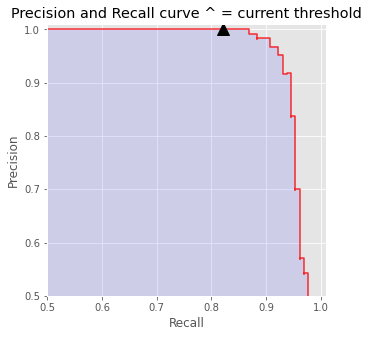

In [15]:
precision_recall_threshold(p, r, thresholds, 0.50)

Confusion Matrix:
     pred_neg  pred_pos
neg       846         0
pos        18       111

Evaluation metrics:
accuracy: 0.9815
sensitivity: 0.8605
specificity: 1.0000


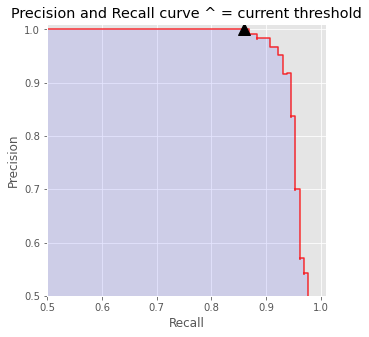

In [16]:
precision_recall_threshold(p, r, thresholds, 0.40)

Confusion Matrix:
     pred_neg  pred_pos
neg       842         4
pos        10       119

Evaluation metrics:
accuracy: 0.9856
sensitivity: 0.9225
specificity: 0.9953


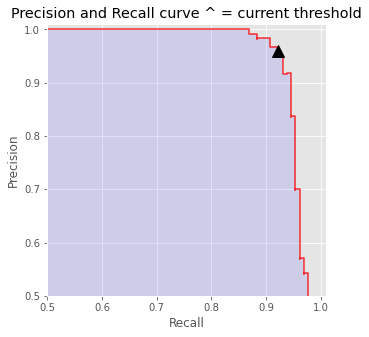

In [17]:
precision_recall_threshold(p, r, thresholds, 0.30)

Confusion Matrix:
     pred_neg  pred_pos
neg       832        14
pos         7       122

Evaluation metrics:
accuracy: 0.9785
sensitivity: 0.9457
specificity: 0.9835


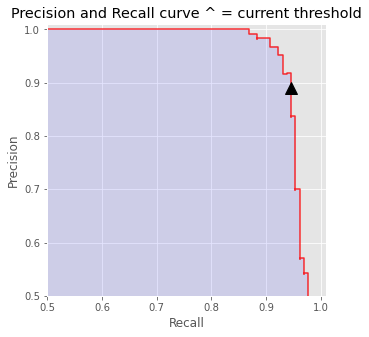

In [18]:
precision_recall_threshold(p, r, thresholds, 0.20)

Confusion Matrix:
     pred_neg  pred_pos
neg       785        61
pos         5       124

Evaluation metrics:
accuracy: 0.9323
sensitivity: 0.9612
specificity: 0.9279


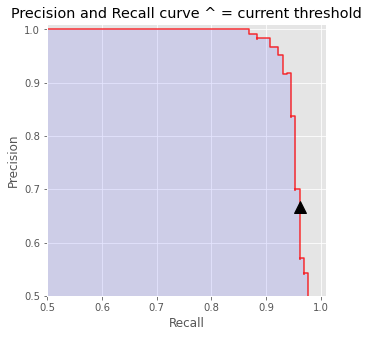

In [19]:
precision_recall_threshold(p, r, thresholds, 0.10)

In the next notebooks we'll pursue as great a sensitivity but not at the cost of a lower specificity. Ideally we can get close to 99% for both metrics.

---